# Анализ A/B Теста
В данном задании вам нужно будет

    проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса
    подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами
    определить характер этих изменений и практическую значимость вводимого изменения
    понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения (локализовать изменение)

Описание  данных:

    userID:  уникальный идентификатор пользователя
    browser:  браузер, который использовал userID
    slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)
    n_clicks: количество кликов, которые пользоваль совершил за n_queries
    n_queries: количество запросов, который совершил userID, пользуясь браузером browser
    n_nonclk_queries: количество запросов пользователя, в которых  им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных  уникальным является сочетание userID и browser

In [2]:
import numpy as np
import pandas as pd

import scipy
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
data = pd.read_csv('ab_test.csv', delimiter = ',', header = 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            566134 non-null  int64 
 1   browser           566134 non-null  object
 2   slot              566134 non-null  object
 3   n_clicks          566134 non-null  int64 
 4   n_queries         566134 non-null  int64 
 5   n_nonclk_queries  566134 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [7]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [8]:
data.shape

(566134, 6)

### Задание 1
Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите  до третьего знака после точки

In [11]:
exp_data = data[data.slot == 'exp']
control_data = data[data.slot == 'control']
print('Experiment data shape: ', exp_data.shape)
print('Control data shape: ', control_data.shape)

Experiment data shape:  (281580, 6)
Control data shape:  (284554, 6)


In [15]:
ans_1 = (exp_data.n_clicks.sum() - control_data.n_clicks.sum()) / control_data.n_clicks.sum() * 100

In [16]:
round(ans_1, 3)

1.614

### Задание 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

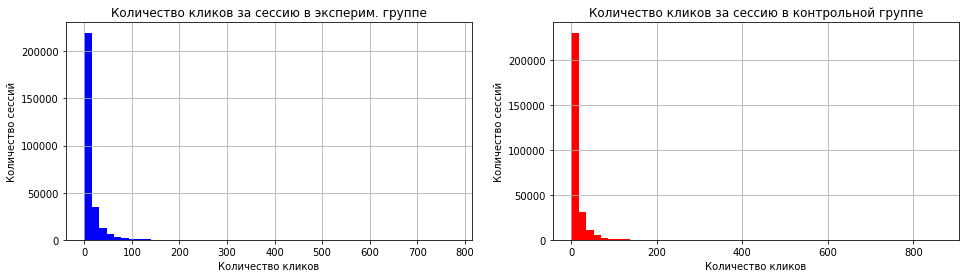

In [23]:
pylab.figure(figsize(16, 4))
pylab.subplot(1,2,1)
exp_data['n_clicks'].hist(color='blue', bins = 50)
pylab.xlabel('Количество кликов')
pylab.ylabel('Количество сессий')
plt.title('Количество кликов за сессию в эксперим. группе')


pylab.subplot(1,2,2)
control_data['n_clicks'].hist(color='red', bins = 50)
pylab.xlabel('Количество кликов')
pylab.ylabel('Количество сессий')
plt.title('Количество кликов за сессию в контрольной группе')
plt.show()

In [17]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [18]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [19]:
np.random.seed(0)

exp_median_nclick_scores = list(map(np.median, get_bootstrap_samples(exp_data.n_clicks.values, 1000)))
exp_mean_nclick_scores = list(map(np.mean, get_bootstrap_samples(exp_data.n_clicks.values, 1000)))
control_median_nclick_scores = list(map(np.median, get_bootstrap_samples(control_data.n_clicks.values, 1000)))
control_mean_nclick_scores = list(map(np.mean, get_bootstrap_samples(control_data.n_clicks.values, 1000)))

In [24]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_median_nclick_scores,
                                                          control_median_nclick_scores)))
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(exp_mean_nclick_scores,
                                                          control_mean_nclick_scores)))

In [26]:
print ("95% доверительный интервал для медианы количества кликов эксперим. группа:",  stat_intervals(exp_median_nclick_scores , 0.05))
print("95% доверительный интервал для медианы количества кликов контрольная группа:",  stat_intervals(control_median_nclick_scores , 0.05))
print("95% доверительный интервал для медианы разности",  stat_intervals(delta_median_scores, 0.05))

95% доверительный интервал для медианы количества кликов эксперим. группа: [5. 5.]
95% доверительный интервал для медианы количества кликов контрольная группа: [4. 4.]
95% доверительный интервал для медианы разности [-1. -1.]


In [27]:
print ("95% доверительный интервал для среднего количества кликов эксперим. группа:",  stat_intervals(exp_mean_nclick_scores , 0.05))
print("95% доверительный интервал для среднего количества кликов контрольная группа:",  stat_intervals(control_mean_nclick_scores , 0.05))
print("95% доверительный интервал для разности средних",  stat_intervals(delta_mean_scores, 0.05))

95% доверительный интервал для среднего количества кликов эксперим. группа: [11.50709079 11.65274416]
95% доверительный интервал для среднего количества кликов контрольная группа: [11.21183071 11.35237354]
95% доверительный интервал для разности средних [-0.41073936 -0.19821372]


Answer:

95% доверительный интервал для разности средних не  содержит ноль, похоже, средние отличаются статистически значимо

95% доверительный интервал для разности медиан не  содержит ноль, похоже, медианы отличаются статистически значимо

### Задание 3

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и  значимым статистически. Последнее утверждение нуждается в дополнительной проверке. 

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах. 

Answer:
все ответы неверные

### Задание 4
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных. 

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных. 

Для простоты рассмотрим одновыборочный t-критерий.  Его статистика имеет вид   $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$ 

 $\bar{X}$  —  среднее значение в выборке — было распределено нормально $N(\mu,\frac{\sigma^2}{n})$
 
 $\frac{n}{\sigma^2}S^2$  — несмещенная оценка дисперсии c масштабирующим коэффициентом —  была распределена по хи-квадрат  c n−1 степенями свободы  $\chi^2(n−1)$ 

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными  в рамках данного вопроса. 

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого 

     Получите из данных n_boot_samples  псевдовыборок. 
    По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared) 
    Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
    Для получившегося вектора  сумм квадратов отклонения от выборочного среднего постройте  qq-plot с помощью scipy.stats.probplot  для хи-квадрат распределения с помощью команды 

In [29]:
np.random.seed(0)
n_boot_samples = 500

control_boot_mean = list(map(np.mean, get_bootstrap_samples(control_data.n_clicks.values, n_boot_samples)))
control_boot_chi_squared = list(map(np.std, get_bootstrap_samples(control_data.n_clicks.values, n_boot_samples)))

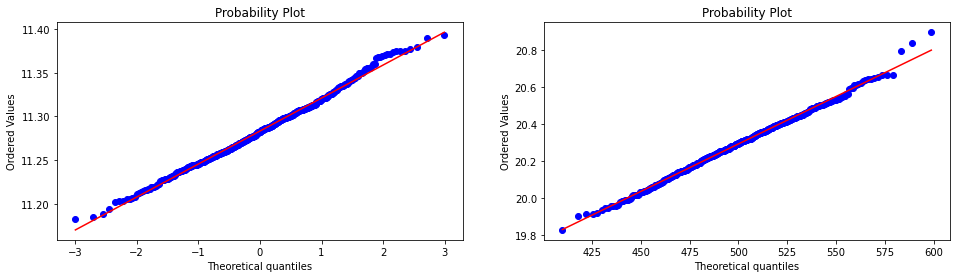

In [38]:
plt.subplot(121)
scipy.stats.probplot(control_boot_mean, dist="norm", plot = pylab)
plt.subplot(122)
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n_boot_samples-1), plot=pylab)
pylab.show()

(0.037774667185630995, 11.283244614378994, 0.997974836460421)

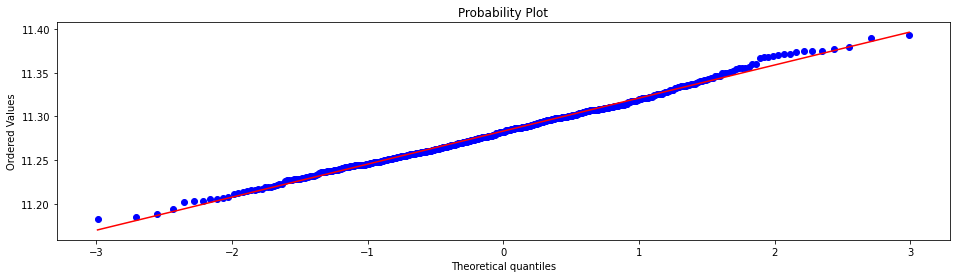

In [40]:
scipy.stats.probplot(control_boot_mean, dist="norm", plot = pylab)[1]

(0.005141548314832188, 17.721573429489954, 0.9984052922206963)

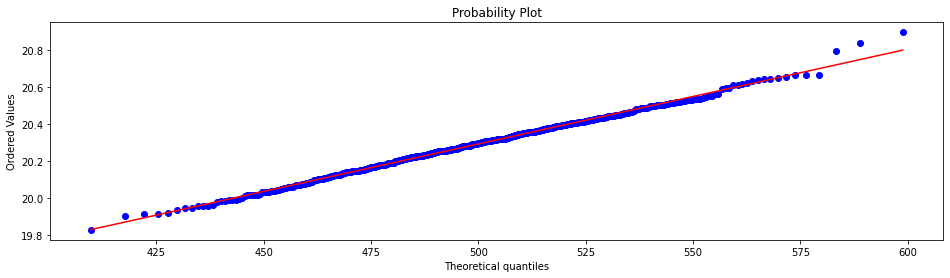

In [41]:
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n_boot_samples-1), plot=pylab)[1]

Answer:

$R^2$ для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99

$R^2$ для выборочного среднего получился больше, чем  0.99

### Задание 5
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control  и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [50]:
n_click_control_by_user = data[data['slot']=='control'].groupby(by='userID')['n_clicks'].agg(np.sum)
n_click_exp_by_user = data[data['slot']=='exp'].groupby(by='userID')['n_clicks'].agg(np.sum)

In [73]:
n_click_control_by_user.mean()

11.287332273762974

In [55]:
n_click_exp_by_user.mean()

11.589351572215314

In [53]:
stats.mannwhitneyu(n_click_control_by_user, n_click_exp_by_user, alternative = 'two-sided')

MannwhitneyuResult(statistic=38901259929.0, pvalue=8.694294377520879e-75)

Answer: Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между  двумя выборками


### Задание 6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $\alpha=0.05$.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [104]:
table = {}
p_vals = []
for name in data.browser.unique():
    table[name] = scipy.stats.mannwhitneyu(
    data[(data.browser== name) & (data.slot=='exp')].n_clicks.values,
    data[(data.browser== name) & (data.slot=='control')].n_clicks.values,
    alternative='two-sided')[1]
    p_vals.append(scipy.stats.mannwhitneyu(
    data[(data.browser== name) & (data.slot=='exp')].n_clicks.values,
    data[(data.browser== name) & (data.slot=='control')].n_clicks.values,
    alternative='two-sided')[1])

In [103]:
df = pd.DataFrame.from_dict(table, orient='index', columns = ['p value'])
df

,p value
Browser #2,0.054488
Browser #4,0.815212
Browser #14,0.000000
Browser #17,0.074801
Browser #20,0.907333
Browser #22,0.514811


In [105]:
import statsmodels.stats.multitest as smm

In [110]:
reject_1, p_corrected_1, a1_1, a2_1 = smm.multipletests(np.array(p_vals), 
                                            alpha = 0.05/6., 
                                            method = 'holm') 

In [111]:
df['p corr. Holm'] = p_corrected_1
df['reject Holm'] = reject_1
df

,p value,p corr. Holm,reject Holm
Browser #2,0.054488,0.272439,False
Browser #4,0.815212,1.000000,False
Browser #14,0.000000,0.000000,True
Browser #17,0.074801,0.299205,False
Browser #20,0.907333,1.000000,False
Browser #22,0.514811,1.000000,False


Answer: 5 

### Задание 7

Для каждого браузера в каждой из двух групп (control  и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений  n_nonclk_queries  на сумму значений  n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче  проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения. 

In [119]:
part_control_by_browser = data[data['slot']=='control'].groupby(by='browser')[['n_nonclk_queries', 'n_queries']].agg(np.sum)
part_exp_by_browser = data[data['slot']=='exp'].groupby(by='browser')[['n_nonclk_queries', 'n_queries']].agg(np.sum)

In [121]:
part_control_by_browser

,n_nonclk_queries,n_queries
browser,,
Browser #14,161252,279998
Browser #17,75837,208921
Browser #2,260259,566239
Browser #20,78548,193752
Browser #22,315470,777135
Browser #4,498254,1060771


In [122]:
part_control_by_browser['n_nonclk_queries'] / part_control_by_browser['n_queries'] *100

browser
Browser #14    57.590411
Browser #17    36.299367
Browser #2     45.962747
Browser #20    40.540485
Browser #22    40.593977
Browser #4     46.970930
dtype: float64

In [123]:
part_exp_by_browser['n_nonclk_queries'] / part_exp_by_browser['n_queries'] *100

browser
Browser #14    43.755617
Browser #17    36.937413
Browser #2     44.982747
Browser #20    38.977376
Browser #22    39.853947
Browser #4     45.142942
dtype: float64

С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.

(?????)По одному из браузеров мы видим значительное уменьшение доли некликнутых запросов, поэтому уже только на этом основании тестируемое изменение можно рекомендовать к применению для всех пользователей. 